In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 데이터셋 경로 설정
dataset_dir = "/home/yycho/deepMUC/202230727_Image/HILOW"
dataset_dir = Path(dataset_dir)

# 이미지 파일 경로 수집
filepaths = list(dataset_dir.glob(r'*/*.jpg'))
print(f"총 {len(filepaths)}개의 이미지 파일을 찾았습니다.")

# 데이터프레임 생성
def create_image_df(filepaths):
    labels = [filepath.parent.name for filepath in filepaths]
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # 데이터프레임 셔플
    return df

image_df = create_image_df(filepaths)
print(image_df.head())

# 레이블 인코딩
label_encoder_img = LabelEncoder()
image_df['Encoded_Label'] = label_encoder_img.fit_transform(image_df['Label'])  # 'High' => 0, 'Low' => 1

# 원-핫 인코딩
image_df['Categorical_Label'] = list(to_categorical(image_df['Encoded_Label']))


총 6227개의 이미지 파일을 찾았습니다.
                                            Filepath Label
0  /home/yycho/deepMUC/202230727_Image/HILOW/LOW/...   LOW
1  /home/yycho/deepMUC/202230727_Image/HILOW/LOW/...   LOW
2  /home/yycho/deepMUC/202230727_Image/HILOW/LOW/...   LOW
3  /home/yycho/deepMUC/202230727_Image/HILOW/LOW/...   LOW
4  /home/yycho/deepMUC/202230727_Image/HILOW/LOW/...   LOW


In [2]:
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df
df = proc_img(filepaths)
df.head(2)

,Filepath,Label
0,/home/yycho/deepMUC/202230727_Image/HILOW/HI/M...,HI
1,/home/yycho/deepMUC/202230727_Image/HILOW/LOW/...,LOW


In [3]:
from sklearn.model_selection import train_test_split

X_image_paths = image_df['Filepath'].astype(str).values
y_image = np.stack(image_df['Categorical_Label'].values)

# 학습용과 테스트용 데이터 분할
X_image_train_paths, X_image_test_paths, y_image_train, y_image_test = train_test_split(
    X_image_paths, y_image, test_size=0.2, random_state=42, stratify=y_image
)

print(f"학습용 이미지 데이터 수: {len(X_image_train_paths)}")
print(f"테스트용 이미지 데이터 수: {len(X_image_test_paths)}")


학습용 이미지 데이터 수: 4981
테스트용 이미지 데이터 수: 1246


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# 데이터 증강 및 전처리를 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

# 제너레이터 함수 정의
def create_generator(filepaths, labels, datagen, batch_size):
    num_samples = len(filepaths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            batch_filepaths = filepaths[batch_indices]
            batch_labels = labels[batch_indices]
            batch_images = []
            for filepath in batch_filepaths:
                img = tf.keras.preprocessing.image.load_img(filepath, target_size=(299, 299))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                batch_images.append(img_array)
            batch_images = np.array(batch_images)
            batch_images = datagen.standardize(batch_images)
            yield batch_images, batch_labels


In [5]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 모델 구성
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # 클래스 수에 따라 조정
image_model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
image_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 설정
checkpoint = ModelCheckpoint('image_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# 배치 크기와 스텝 계산
batch_size = 32
train_steps = len(X_image_train_paths) // batch_size
test_steps = len(X_image_test_paths) // batch_size

# 제너레이터 생성
train_generator = create_generator(X_image_train_paths, y_image_train, train_datagen, batch_size)
test_generator = create_generator(X_image_test_paths, y_image_test, test_datagen, batch_size)

# 모델 학습
history_img = image_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=test_generator,
    validation_steps=test_steps,
    epochs=10,
    callbacks=[checkpoint, reduce_lr, early_stop]
)


2024-10-29 22:09:01.605693: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 22:09:02.024246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79048 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


Epoch 1/10


2024-10-29 22:09:19.236221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8906
2024-10-29 22:09:21.608506: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


155/155 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.7468
Epoch 1: val_accuracy improved from -inf to 0.69737, saving model to image_model.h5
155/155 [==============================] - 91s 479ms/step - loss: 0.5066 - accuracy: 0.7468 - val_loss: 0.6356 - val_accuracy: 0.6974 - lr: 1.0000e-04
Epoch 2/10
155/155 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9327
Epoch 2: val_accuracy improved from 0.69737 to 0.87747, saving model to image_model.h5
155/155 [==============================] - 76s 473ms/step - loss: 0.1761 - accuracy: 0.9327 - val_loss: 0.2959 - val_accuracy: 0.8775 - lr: 1.0000e-04
Epoch 3/10
155/155 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9594
Epoch 3: val_accuracy did not improve from 0.87747
155/155 [==============================] - 72s 464ms/step - loss: 0.1066 - accuracy: 0.9594 - val_loss: 0.3463 - val_accuracy: 0.8692 - lr: 1.0000e-04
Epoch 4/10
155/155 [============================

In [6]:
# 최적의 모델 로드
best_image_model = tf.keras.models.load_model('image_model.h5')

# 테스트 데이터 평가
test_loss, test_accuracy = best_image_model.evaluate(test_generator, steps=test_steps)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")


38/38 [==============================] - 15s 358ms/step - loss: 0.1258 - accuracy: 0.9556
테스트 손실: 0.12580740451812744
테스트 정확도: 0.9555920958518982


In [7]:
# 모델을 지정된 경로에 저장
best_image_model.save('/home/yycho/deepMUC/202230727_Image/da_image_model.h5')


In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os

# RNA 데이터 로드 및 전처리
rna_df = pd.read_csv('/home/yycho/deepMUC/202230727_Image/rna_expression_data.tsv', sep='\t')
rna_df.rename(columns={'genes': 'SampleID'}, inplace=True)

# 레이블 인코딩 및 원-핫 인코딩
label_encoder_rna = LabelEncoder()
rna_df['Encoded_Label'] = label_encoder_rna.fit_transform(rna_df['Group'])
rna_df['Categorical_Label'] = list(to_categorical(rna_df['Encoded_Label']))

# 이미지 데이터 전처리 함수
def extract_sample_id(filepath):
    filename = os.path.basename(filepath)
    sample_id = filename.split('_')[0]
    return sample_id

# SampleID 추출
image_df['SampleID'] = image_df['Filepath'].apply(lambda x: extract_sample_id(str(x)))

# RNA 데이터와 이미지 데이터 각각 분할 (데이터 누수 방지)
rna_train, rna_test = train_test_split(rna_df, test_size=0.1, random_state=42, stratify=rna_df['Encoded_Label'])
image_train, image_test = train_test_split(image_df, test_size=0.1, random_state=42, stratify=image_df['SampleID'])

# 공통 SampleID만 포함하여 병합 (분할 후 병합)
common_train_ids = set(rna_train['SampleID']).intersection(set(image_train['SampleID']))
common_test_ids = set(rna_test['SampleID']).intersection(set(image_test['SampleID']))

filtered_rna_train = rna_train[rna_train['SampleID'].isin(common_train_ids)].copy()
filtered_rna_test = rna_test[rna_test['SampleID'].isin(common_test_ids)].copy()
filtered_image_train = image_train[image_train['SampleID'].isin(common_train_ids)].copy()
filtered_image_test = image_test[image_test['SampleID'].isin(common_test_ids)].copy()

# 이미지 전처리 수행 (훈련, 테스트 각각에 대해)
def preprocess_images(filepaths):
    images = []
    for filepath in filepaths:
        img = tf.keras.preprocessing.image.load_img(filepath, target_size=(299, 299))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.keras.applications.densenet.preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

X_train_images = preprocess_images(filtered_image_train['Filepath'].astype(str).values)
X_test_images = preprocess_images(filtered_image_test['Filepath'].astype(str).values)

# 이미지 예측 수행 (훈련, 테스트 각각)
y_train_image_pred_proba = best_image_model.predict(X_train_images)
y_train_image_pred_class = np.argmax(y_train_image_pred_proba, axis=1)

y_test_image_pred_proba = best_image_model.predict(X_test_images)
y_test_image_pred_class = np.argmax(y_test_image_pred_proba, axis=1)

# 예측 결과를 데이터프레임에 추가 (훈련, 테스트 각각)
filtered_image_train['Image_Pred_Class'] = y_train_image_pred_class
filtered_image_train['Image_Pred_Prob'] = y_train_image_pred_proba[:, 1]
filtered_image_test['Image_Pred_Class'] = y_test_image_pred_class
filtered_image_test['Image_Pred_Prob'] = y_test_image_pred_proba[:, 1]

filtered_image_train['Image_Pred_Label'] = label_encoder_rna.inverse_transform(y_train_image_pred_class)
filtered_image_test['Image_Pred_Label'] = label_encoder_rna.inverse_transform(y_test_image_pred_class)

# 필터링된 이미지 예측 결과와 RNA 데이터를 병합 (훈련, 테스트 각각)
train_merged_df = pd.merge(filtered_rna_train, filtered_image_train[['SampleID', 'Image_Pred_Class', 'Image_Pred_Label', 'Image_Pred_Prob']], on='SampleID', how='inner')
test_merged_df = pd.merge(filtered_rna_test, filtered_image_test[['SampleID', 'Image_Pred_Class', 'Image_Pred_Label', 'Image_Pred_Prob']], on='SampleID', how='inner')

# 입력 특징 및 레이블 준비
y_train_combined = np.stack(train_merged_df['Categorical_Label'].values)
y_test_combined = np.stack(test_merged_df['Categorical_Label'].values)

# 융합 모델을 위한 입력 특징 구성
X_train_combined = train_merged_df.drop(columns=['SampleID', 'Group', 'Encoded_Label', 'Categorical_Label', 'Image_Pred_Label']).values
X_test_combined = test_merged_df.drop(columns=['SampleID', 'Group', 'Encoded_Label', 'Categorical_Label', 'Image_Pred_Label']).values

# 특징 스케일링 (훈련 및 테스트 세트 각각)
scaler = StandardScaler()
X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_combined_scaled = scaler.transform(X_test_combined)


2024-10-29 22:29:03.190910: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5406972480 exceeds 10% of free system memory.
2024-10-29 22:29:09.484785: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5406972480 exceeds 10% of free system memory.


2024-10-29 22:36:21.985836: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5406972480 exceeds 10% of free system memory.


X_train_combined_scaled shape: (5040, 25)
y_train_combined shape: (5040, 2)
Epoch 1/10
625/630 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9908 - auc: 0.9997
Epoch 1: val_accuracy improved from -inf to 0.91935, saving model to combined_model.h5
630/630 [==============================] - 4s 5ms/step - loss: 0.1243 - accuracy: 0.9909 - auc: 0.9997 - val_loss: 0.3509 - val_accuracy: 0.9194 - val_auc: 0.9787
Epoch 2/10
629/630 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9996 - auc: 1.0000
Epoch 2: val_accuracy did not improve from 0.91935
630/630 [==============================] - 3s 4ms/step - loss: 0.0405 - accuracy: 0.9996 - auc: 1.0000 - val_loss: 0.3122 - val_accuracy: 0.9194 - val_auc: 0.9649
Epoch 3/10
621/630 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9998 - auc: 1.0000
Epoch 3: val_accuracy improved from 0.91935 to 0.93548, saving model to combined_model.h5
630/630 [==============================]

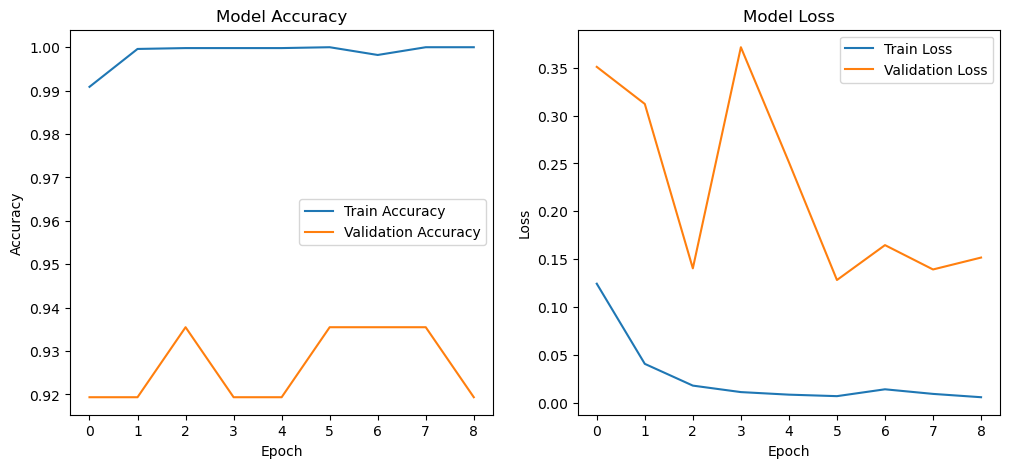

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

# RNA 데이터 로드 및 전처리
rna_df = pd.read_csv('/home/yycho/deepMUC/202230727_Image/rna_expression_data.tsv', sep='\t')
rna_df.rename(columns={'genes': 'SampleID'}, inplace=True)

# 레이블 인코딩 및 원-핫 인코딩
label_encoder_rna = LabelEncoder()
rna_df['Encoded_Label'] = label_encoder_rna.fit_transform(rna_df['Group'])
rna_df['Categorical_Label'] = list(to_categorical(rna_df['Encoded_Label']))

# 이미지 데이터 전처리 함수
def extract_sample_id(filepath):
    filename = os.path.basename(filepath)
    sample_id = filename.split('_')[0]
    return sample_id

# SampleID 추출
image_df['SampleID'] = image_df['Filepath'].apply(lambda x: extract_sample_id(str(x)))

# RNA 데이터와 이미지 데이터 각각 분할 (데이터 누수 방지)
rna_train, rna_test = train_test_split(rna_df, test_size=0.1, random_state=42, stratify=rna_df['Encoded_Label'])
image_train, image_test = train_test_split(image_df, test_size=0.1, random_state=42, stratify=image_df['SampleID'])

# 공통 SampleID만 포함하여 병합 (분할 후 병합)
common_train_ids = set(rna_train['SampleID']).intersection(set(image_train['SampleID']))
common_test_ids = set(rna_test['SampleID']).intersection(set(image_test['SampleID']))

filtered_rna_train = rna_train[rna_train['SampleID'].isin(common_train_ids)].copy()
filtered_rna_test = rna_test[rna_test['SampleID'].isin(common_test_ids)].copy()
filtered_image_train = image_train[image_train['SampleID'].isin(common_train_ids)].copy()
filtered_image_test = image_test[image_test['SampleID'].isin(common_test_ids)].copy()

# 이미지 전처리 수행 (훈련, 테스트 각각에 대해)
def preprocess_images(filepaths):
    images = []
    for filepath in filepaths:
        img = tf.keras.preprocessing.image.load_img(filepath, target_size=(299, 299))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.keras.applications.densenet.preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

X_train_images = preprocess_images(filtered_image_train['Filepath'].astype(str).values)
X_test_images = preprocess_images(filtered_image_test['Filepath'].astype(str).values)

# 이미지 예측 수행 (훈련, 테스트 각각)
y_train_image_pred_proba = best_image_model.predict(X_train_images)
y_train_image_pred_class = np.argmax(y_train_image_pred_proba, axis=1)

y_test_image_pred_proba = best_image_model.predict(X_test_images)
y_test_image_pred_class = np.argmax(y_test_image_pred_proba, axis=1)

# 예측 결과를 데이터프레임에 추가 (훈련, 테스트 각각)
filtered_image_train['Image_Pred_Class'] = y_train_image_pred_class
filtered_image_train['Image_Pred_Prob'] = y_train_image_pred_proba[:, 1]
filtered_image_test['Image_Pred_Class'] = y_test_image_pred_class
filtered_image_test['Image_Pred_Prob'] = y_test_image_pred_proba[:, 1]

filtered_image_train['Image_Pred_Label'] = label_encoder_rna.inverse_transform(y_train_image_pred_class)
filtered_image_test['Image_Pred_Label'] = label_encoder_rna.inverse_transform(y_test_image_pred_class)

# 필터링된 이미지 예측 결과와 RNA 데이터를 병합 (훈련, 테스트 각각)
train_merged_df = pd.merge(filtered_rna_train, filtered_image_train[['SampleID', 'Image_Pred_Class', 'Image_Pred_Label', 'Image_Pred_Prob']], on='SampleID', how='inner')
test_merged_df = pd.merge(filtered_rna_test, filtered_image_test[['SampleID', 'Image_Pred_Class', 'Image_Pred_Label', 'Image_Pred_Prob']], on='SampleID', how='inner')

# 입력 특징 및 레이블 준비
y_train_combined = np.stack(train_merged_df['Categorical_Label'].values)
y_test_combined = np.stack(test_merged_df['Categorical_Label'].values)

# 융합 모델을 위한 입력 특징 구성
X_train_combined = train_merged_df.drop(columns=['SampleID', 'Group', 'Encoded_Label', 'Categorical_Label', 'Image_Pred_Label']).values
X_test_combined = test_merged_df.drop(columns=['SampleID', 'Group', 'Encoded_Label', 'Categorical_Label', 'Image_Pred_Label']).values

# 특징 스케일링
scaler = StandardScaler()
X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_combined_scaled = scaler.transform(X_test_combined)

# 데이터 분할 확인
print(f"X_train_combined_scaled shape: {X_train_combined_scaled.shape}")
print(f"y_train_combined shape: {y_train_combined.shape}")

# 모델 정의
input_dim = X_train_combined_scaled.shape[1]
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_dim=input_dim),
    GaussianNoise(0.1),  # 노이즈 추가
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(y_train_combined.shape[1], activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', AUC(name='auc')])

# 콜백 설정
checkpoint_combined = ModelCheckpoint('combined_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop_combined = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# 모델 학습
history_combined = model.fit(
    X_train_combined_scaled, y_train_combined,
    validation_data=(X_test_combined_scaled, y_test_combined),
    epochs=10,
    batch_size=8,
    callbacks=[checkpoint_combined, early_stop_combined]
)

# 최적의 모델 로드
best_combined_model = tf.keras.models.load_model('combined_model.h5', custom_objects={'AUC': AUC})

# 테스트 데이터 평가
test_loss, test_accuracy, test_auc = best_combined_model.evaluate(X_test_combined_scaled, y_test_combined)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")
print(f"테스트 AUC: {test_auc}")

# 예측 수행
y_pred_proba = best_combined_model.predict(X_test_combined_scaled)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_combined, axis=1)

# 분류 보고서
print("\nClassification Report:")
print(classification_report(y_true, y_pred_class))

# 혼동 행렬
conf_mat = confusion_matrix(y_true, y_pred_class)
print("\nConfusion Matrix:")
print(conf_mat)

# 학습 곡선 시각화
plt.figure(figsize=(12, 5))

# 정확도 시각화
plt.subplot(1, 2, 1)
plt.plot(history_combined.history['accuracy'], label='Train Accuracy')
plt.plot(history_combined.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(history_combined.history['loss'], label='Train Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [18]:
best_combined_model.save('/home/yycho/deepMUC/202230727_Image/ma_combined_model.h5')
